# Qiskit Workshop: Computing molecular energy states with Qiskit Nature



In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
# Import other needed libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from qiskit_nature import settings

settings.use_pauli_sum_op = False

---

## Introduction

<center>
<img src="https://github.com/Qiskit/qiskit-nature/blob/main/docs/_static/orbitals.png?raw=true" width=300>
</center>

**Goal**: Solve non-relativistic time independent Schroedinger equation,

<center>
    $\mathcal{H}_{\text{el}} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle$
</center>

to find the energies $E_n$. The ground state energy, $E_0$, given by:

<center>
    $E_0 = \frac{\langle \Psi_0 | H_{\text{el}} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}$
</center>

**Solution**: Use eigenvalue solver to find energies $E_n$.

---

## Qiskit Nature features
- Interfaces to common classical chemistry libraries/programs ("drivers")
    - Gaussian
    - PSI4
    - PyQuante
    - PYSCF
- Functions to map various operators to qubit operators
- Common ansatz preparation circuits for variational solvers

---

## Setting up the problem

### Step 1: Create molecule and the driver

In [4]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

# Create molecule
molecule = MoleculeInfo(['H', 'H'], [(0., 0., 0.), (0., 0., 0.735)],
                        charge=0, 
                        multiplicity=1)

# Instantiate driver
driver = PySCFDriver.from_molecule(molecule = molecule, basis='sto3g')

<br>

*Step 2a:* Get the `ElectronicStructureProblem` object by running the driver and compute Second quantization operator

In [5]:
es_problem = driver.run()
second_q_op = es_problem.hamiltonian.second_q_op()
print(second_q_op)

/home/wagnerse/.conda/envs/qiskit/lib/python3.9/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211568 * ( +_2 +_0 -_1 -_3 )
+ 0.0904655

<br>

*Step 2b:* Map to qubit spin operators

Available mappings:
- Jordan-Wigner
- Parity
- Bravyi-Kitaev

<img src=https://qiskit.org/documentation/nature/_images/jw_mapping.png>

In [6]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

jw_qubit_mapper =JordanWignerMapper()
jw_qubit_op = jw_qubit_mapper.map(second_q_op)
print(jw_qubit_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.0452328 +0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.16614543+0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [7]:
from qiskit_nature.second_q.mappers import ParityMapper

pr_qubit_mapper =ParityMapper(num_particles=es_problem.num_particles)
pr_qubit_op = pr_qubit_mapper.map(second_q_op)
print(pr_qubit_op)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


---

## Solve for ground state energy using VQE

<img src=https://qiskit.org/documentation/nature/_images/vqe.png width=1000px>

### Step 1: Create VQE solver

#### Create/Instatiate a parameterized ansatz circuit, then pass to `VQE` class

Available ansatz circuits / variational forms:
- `TwoLocal`
- `EfficientSU2`
- `UCC` (Unitary coupled cluster)

In [8]:
n = jw_qubit_op.num_qubits
#n = pr_qubit_op.num_qubits

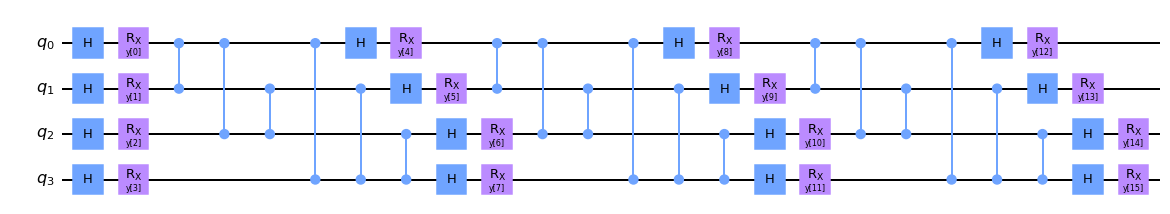

In [9]:
from qiskit.circuit.library import TwoLocal

tl_circ = TwoLocal(num_qubits = n, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz',
                      entanglement='full', reps=3, parameter_prefix = 'y')
tl_circ.decompose().draw()

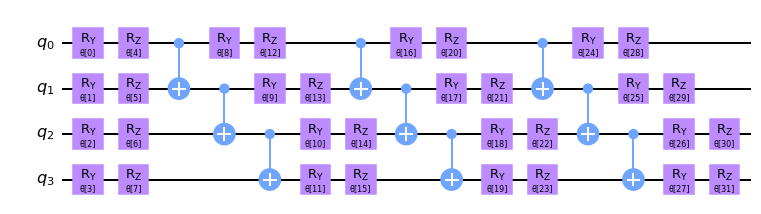

In [10]:
from qiskit.circuit.library import EfficientSU2

su2_circ = EfficientSU2(num_qubits=n, entanglement='linear')
su2_circ.decompose().draw()

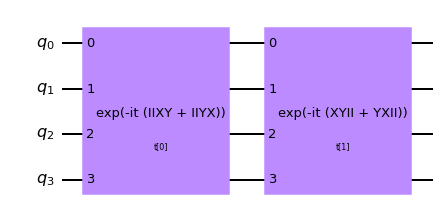

In [11]:
from qiskit_nature.second_q.circuit.library import UCC

ucc_circ = UCC(excitations='s',
               qubit_mapper=jw_qubit_mapper, 
               num_particles=es_problem.num_particles, 
               num_spatial_orbitals=es_problem.num_spatial_orbitals)
ucc_circ.decompose().draw()

<br> 

Now, create the VQE solver with the desired ansatz

In [12]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP, COBYLA

vqe_solver = VQE(Estimator(), su2_circ, COBYLA())

<br>

### Step 2: Run ground state solver

In [13]:
# Choose your mapper!

# JW mapping (uses 4 qubits)
qubit_mapper = jw_qubit_mapper

# Parity mapping using 2 qubits
#qubit_mapper = pr_qubit_mapper

<br> 

Using the `VQE` class with `EfficientSU2`

In [14]:
# Callback function to display intermediate results
def callback(eval_count, params, value, metadata):
    if eval_count % 10 == 0:
        print("Iteration:", eval_count, " value=", value)
    
vqe_solver.callback = callback

In [15]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# Using the VQE class with EfficientSU2 ansatz
su2_gsc = GroundStateEigensolver(qubit_mapper, vqe_solver)
result = su2_gsc.solve(es_problem)

print(result)

Iteration: 10  value= -0.8163478529175907
Iteration: 20  value= -1.006548704912117
Iteration: 30  value= -1.2624270351998104
Iteration: 40  value= -1.0610303421775713
Iteration: 50  value= -1.3672453666370594
Iteration: 60  value= -1.468463770922675
Iteration: 70  value= -1.2891192781421672
Iteration: 80  value= -1.4587251991356802
Iteration: 90  value= -1.6505076063877562
Iteration: 100  value= -1.6724733336195723
Iteration: 110  value= -1.6864538194150436
Iteration: 120  value= -1.6620853612701068
Iteration: 130  value= -1.6939391815480451
Iteration: 140  value= -1.7117269578902963
Iteration: 150  value= -1.7455541720164147
Iteration: 160  value= -1.7670237072266104
Iteration: 170  value= -1.7736873857454711
Iteration: 180  value= -1.7852680863323944
Iteration: 190  value= -1.7721235090414325
Iteration: 200  value= -1.7931962361907305
Iteration: 210  value= -1.8108074138923587
Iteration: 220  value= -1.8156146043730936
Iteration: 230  value= -1.8227827238493246
Iteration: 240  value=

### Try initializing the state first using HartreeFock

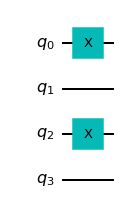

In [16]:
from qiskit_nature.second_q.circuit.library import HartreeFock

init_state = HartreeFock(num_spatial_orbitals=es_problem.num_spatial_orbitals,
                         num_particles=es_problem.num_particles,
                         qubit_mapper=qubit_mapper)


init_state.draw()

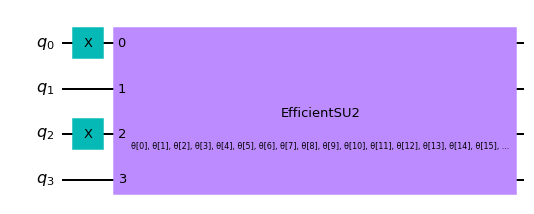

In [17]:
su2_init_circ = init_state.compose(su2_circ)
su2_init_circ.draw()

In [18]:
vqe_solver = VQE(Estimator(), su2_init_circ, COBYLA(), callback=callback)

su2_init_gsc = GroundStateEigensolver(qubit_mapper, vqe_solver)
result = su2_init_gsc.solve(es_problem)

print(result)

Iteration: 10  value= -0.9806457445663287
Iteration: 20  value= -1.1025904894512002
Iteration: 30  value= -1.341589908906051
Iteration: 40  value= -1.3004117833291877
Iteration: 50  value= -1.4838002289865881
Iteration: 60  value= -1.4524592197036592
Iteration: 70  value= -1.4161285712705174
Iteration: 80  value= -1.372870856173128
Iteration: 90  value= -1.6195461364159944
Iteration: 100  value= -1.703799001633005
Iteration: 110  value= -1.7241506336400496
Iteration: 120  value= -1.737976251557101
Iteration: 130  value= -1.7373569466792285
Iteration: 140  value= -1.7687046911367335
Iteration: 150  value= -1.7597431286299998
Iteration: 160  value= -1.773443555490883
Iteration: 170  value= -1.7662688571082386
Iteration: 180  value= -1.8021950729139329
Iteration: 190  value= -1.8050680523189435
Iteration: 200  value= -1.8056574555006055
Iteration: 210  value= -1.8034212863858416
Iteration: 220  value= -1.8187447391817417
Iteration: 230  value= -1.8220826403719574
Iteration: 240  value= -1

<br>

Check against classical solver

In [19]:
# Check against classical solver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

np_gsc = GroundStateEigensolver(qubit_mapper, numpy_solver)
np_result = np_gsc.solve(es_problem)

print(np_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


---

## Calculating bond dissociation profile

### Step 1: Create molecule with `degrees_of_freedom` parameter

In [20]:
# Specify degree of freedom (points of interest)
n_points = 10
points = np.linspace(0.25, 2, n_points)

<br>

### Step 2: Compute potential energy surface using by changing the atom distance

In [21]:
energies = []
vqe_solver.callback = None
for dist in points:
    molecule.coords[1] = (0., 0., dist)
    driver = PySCFDriver.from_molecule(molecule = molecule, basis='sto3g')
    problem = driver.run()
    su2_gsc = GroundStateEigensolver(qubit_mapper, vqe_solver)
    result = su2_gsc.solve(problem)
    energies.append(result.total_energies)    
    print("Distance:", dist, ", energy:", result.total_energies)

Distance: 0.25 , energy: [-0.30492669]
Distance: 0.4444444444444444 , energy: [-0.9841056]
Distance: 0.6388888888888888 , energy: [-1.12638885]
Distance: 0.8333333333333334 , energy: [-1.12652951]
Distance: 1.0277777777777777 , energy: [-1.09413285]
Distance: 1.2222222222222223 , energy: [-1.05180699]
Distance: 1.4166666666666667 , energy: [-0.95795244]
Distance: 1.6111111111111112 , energy: [-0.98160248]
Distance: 1.8055555555555556 , energy: [-0.94927209]
Distance: 2.0 , energy: [-0.9252545]


Text(0, 0.5, 'Energy')

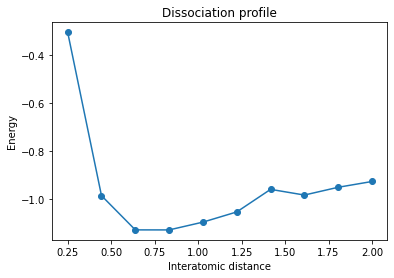

In [22]:
# Plot
fig = plt.figure()
plt.plot(points, energies, marker='o')
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

---

## Computing excited state energies

<img src=https://qiskit.org/documentation/nature/_images/H2_es.png width=200>

Use *Quantum equation of motion* (QEOM) method.

See article: P. Allitrault et al, [arxiv 1910.12890](https://arxiv.org/abs/1910.12890)

In [23]:
from qiskit_nature.second_q.algorithms import QEOM

qeom_solver = QEOM(su2_gsc, Estimator(), "sd")

qeom_results = qeom_solver.solve(es_problem)

print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857047978823
  - computed part:      -1.857047978823
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137078984374
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.245418850414
> Total excited state energy (Hartree): -0.525449855965
  2: 
* Electronic excited state energy (Hartree): -0.883551600593
> Total excited state energy (Hartree): -0.163582606144
  3: 
* Electronic excited state energy (Hartree): -0.22574161234
> Total excited state energy (Hartree): 0.494227382109
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 0.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 0.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 0.000 S: 0.000 S^2: 0.000 M: 0.000
  3:  # Particles: 0.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole 

In [24]:
import qiskit.tools.jupyter
%qiskit_version_table